In [21]:
from PIL import Image
from matplotlib import pyplot as plt
from glob import glob as glob
import numpy as np
import cv2
import random
import os
import time
import copy
from collections import defaultdict
from tqdm import tqdm as tqdm

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models
import torch.nn as nn
from torchsummary import summary

In [65]:
## GLOBAL SETTINGS
random.seed(0)
im_w_training = 256
im_h_training = 256
b_size = 2
num_class = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

val_org_imgs = glob('../experiments/assignment_dataset/original_images/*')
val_lable_imgs = glob('../experiments/assignment_dataset/tagged_images/*')

In [66]:
def make_dataset(dir):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname):
                path = os.path.join(root, fname)
                images.append(path)

    return images
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP', '.tiff'
]

def decode_labels(mask, num_images=1, num_classes=6):
    n, h, w, c = mask.shape  # batch_size, 256, 256, 1
    assert (
        n >= num_images
    ), 'Batch size %d should be greater or equal than number of images to save %d.' % (
        n, num_images)
    outputs = np.zeros((n, h, w, 3), dtype=np.uint8)
    for i in range(n):
        img = Image.new('RGB', (len(mask[i, 0]), len(mask[i])))
        pixels = img.load()
        for j_, j in enumerate(mask[i, :, :, 0]):
            for k_, k in enumerate(j):
                if k < num_classes:
                    pixels[k_, j_] = label_colours[k]
        outputs[i] = np.array(img)
    return outputs


label_colours = [
    (255, 255, 255),
    (255, 0, 0),
    (0, 255, 0),
    (0, 0, 255),
    (255,255, 0),
    (0, 0, 0)
]

In [67]:
class RegularDataset(Dataset):
    def __init__(self, original_img_paths, original_seg_paths, augment):

        self.transforms = augment

        self.img_width = im_w_training
        self.img_height = im_h_training

        self.A_paths = original_img_paths
        self.B_paths = original_seg_paths

        self.dataset_size = len(self.A_paths)

    def __getitem__(self, index):

        # input A (RGB source)
        A_path = self.A_paths[index]
        A = Image.open(A_path)
        A = A.resize((self.img_width, self.img_height), Image.BICUBIC)
        A_tensor = self.transforms(A)

        # input B (seg map target)
        B_path = self.B_paths[index]
        B = self.parsing_embedding(B_path)  # channel(20), H, W
        B_tensor = torch.from_numpy(B)

        input_dict = {
            'source_img': A_tensor,
            'target_img': B_tensor,
            'source_img_path': A_path,
            'target_img_path': B_path
        }

        return input_dict

    def parsing_embedding(self, img_path):
        test_img = Image.open(img_path)
        test_img = test_img.resize((self.img_width, self.img_height),
                                   Image.BICUBIC)
        test_img = np.array(test_img)
        unique_channel_values = [0, 50, 100, 150, 200, 250]
        parse_emb = []

        for each_channel_val in unique_channel_values:
            parse_emb.append(
                (test_img == each_channel_val).astype(np.float32).tolist())

        parse = np.array(parse_emb).astype(np.float32)
        return parse

    def __len__(self):
        return len(self.A_paths)

    def name(self):
        return 'RegularDataset'

In [68]:
augment = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

val_dataset = RegularDataset(val_org_imgs, val_lable_imgs, augment)
val_dataloader = DataLoader(val_dataset,
                            shuffle=True,
                            drop_last=False,
                            num_workers=6,
                            batch_size=b_size,
                            pin_memory=True)

In [69]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


base_model = models.resnet18(pretrained=True)
base_model.conv1 = torch.nn.Conv2d(1,
                                   64,
                                   kernel_size=(7, 7),
                                   stride=(2, 2),
                                   padding=(3, 3),
                                   bias=False)


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

#         self.base_model = models.resnet18(pretrained=False)
#         self.base_model.conv1 = torch.nn.Conv2d(1,
#                                                 64,
#                                                 kernel_size=(7, 7),
#                                                 stride=(2, 2),
#                                                 padding=(3, 3),
#                                                 bias=False)

        self.base_layers = list(base_model.children())

        self.layer0 = nn.Sequential(
            *self.base_layers[:3])  # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(
            *self.base_layers[3:5])  # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2,
                                    mode='bilinear',
                                    align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(1, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('../experiments/test_model_gray.pt')
model.eval()

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [76]:
# HELPER FUNCTION FOR PREDICTION

def predict_unet(inputs):
    inputs = inputs.unsqueeze_(0)
    inputs = inputs.to(device)

    generate_parse = model(inputs)
    generate_parse = F.softmax(generate_parse, dim=1)

    generate_parse_vis = torch.argmax(generate_parse, dim=1,
                                      keepdim=True).permute(0, 2, 3,
                                                            1).contiguous()
    generate_parse_vis_show = decode_labels(generate_parse_vis)
    
    return generate_parse , generate_parse_vis , generate_parse_vis_show

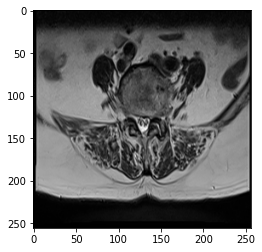

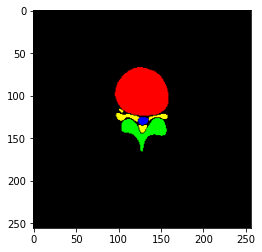

In [78]:
# RANDOM TEST IMAGE 
index = random.choice(range(0, len(val_dataset), 1))
results = val_dataset[index]
source_img = results['source_img'].float().cuda()

inputs = source_img

generate_parse , generate_parse_vis , generate_parse_vis_show = predict_unet(inputs)

target_parse_path = results['source_img_path']
plt.show('source image')
test_img = Image.open(target_parse_path)
test_img = test_img.resize((256,256), Image.BICUBIC)
plt.imshow(test_img,cmap='gray')
plt.show('predicted image')
plt.imshow(np.squeeze(generate_parse_vis_show))

In [79]:
# SAVE THE PREDICTION OUTPUT
for index in range(0,len(val_dataset)):
    results = val_dataset[index]
    source_img = results['source_img'].float().cuda()

    inputs = source_img

    generate_parse , generate_parse_vis , generate_parse_vis_show = predict_unet(inputs)

    save_img = np.squeeze(generate_parse_vis.to('cpu').numpy())
    save_img = Image.fromarray(save_img.astype('uint8'))
    target_path = './prediction_seg/256by256/' + os.path.basename(results['source_img_path'])
    print('saving image with path', target_path)
    save_img.save(target_path)

saving image with path ./prediction/256by256/midaxial2217.png
saving image with path ./prediction/256by256/midaxial2239.png
saving image with path ./prediction/256by256/midaxial1775.png
saving image with path ./prediction/256by256/midaxial1792.png
saving image with path ./prediction/256by256/midaxial2248.png
saving image with path ./prediction/256by256/midaxial2056.png
saving image with path ./prediction/256by256/midaxial2261.png
saving image with path ./prediction/256by256/midaxial2245.png
saving image with path ./prediction/256by256/midaxial2015.png
saving image with path ./prediction/256by256/midaxial1976.png
saving image with path ./prediction/256by256/midaxial1800.png
